# SARIMA

---

In [ ]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools as itr

# Loading the data

In [ ]:
cal = pd.read_csv('calendar.csv')
stv = pd.read_csv('sales_train_validation.csv')

In [ ]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [ ]:
print(cal['event_name_1'].unique())
print(cal['event_name_2'].unique())

[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


# Helper functions

To assess the performances of our model:

In [ ]:
def RMSSE(y_train, y_test, y_pred):
    MSE = mean_squared_error(y_test, y_pred)
    y_train_s = y_train.shift()
    S = float(np.sum((y_train - y_train.shift())**2)) / (len(y_train) - 1)
    return np.sqrt(MSE/S)

# Focusing on one store

Preliminary analysis:

In [ ]:
store = 'CA_1'

data = stv[stv['store_id'] == store]

In [ ]:
#selecting all the columns that contain d_
d_cols = [c for c in stv.columns if 'd_' in c] 
all_data = data[d_cols].sum(axis=0).T.reset_index()
all_data.columns = ['d','sales']
print(all_data)

           d  sales
0        d_1   4337
1        d_2   4155
2        d_3   2816
3        d_4   3051
4        d_5   2630
...      ...    ...
1908  d_1909   3722
1909  d_1910   3709
1910  d_1911   4387
1911  d_1912   5577
1912  d_1913   6113

[1913 rows x 2 columns]


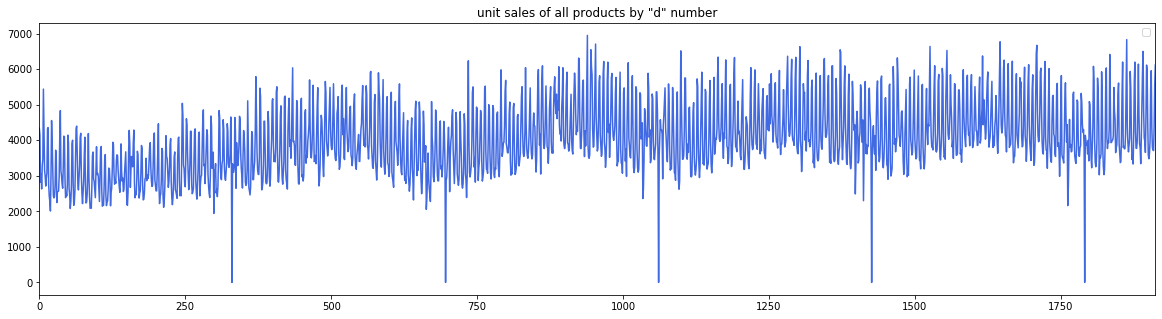

In [ ]:
# Visualization of the time series
all_data.plot(figsize=(20, 5),
          title='unit sales of all products by "d" number', color= 'royalblue')
plt.legend('')
plt.show()

### Dealing with the outliers = special events

There are pics at special events. Let's smooth everything to handle the outliers:

In [ ]:
# Merge calendar on our items' data
all_data_merged = all_data.merge(cal, how='left', validate='1:1')
all_data_merged.head()

,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,4337,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,4155,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,2816,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,3051,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,2630,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


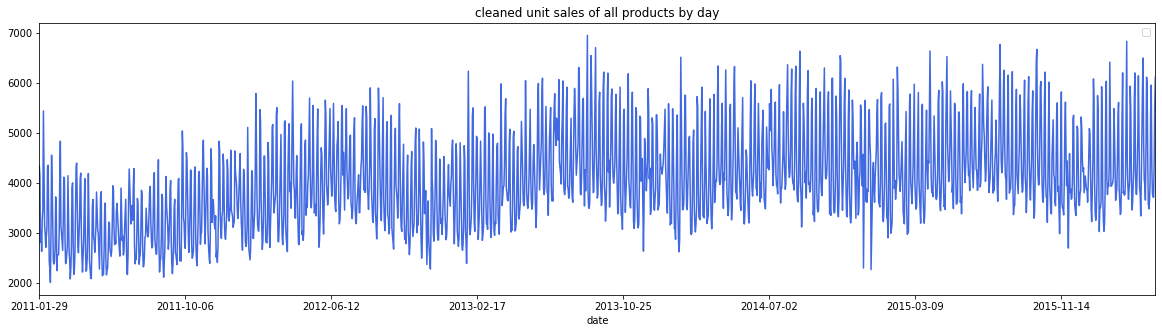

In [ ]:
#Getting the sales data 
y = all_data_merged.set_index('date')['sales']

#Detect days that have either event_1 or event_2
places = all_data_merged.loc[~(all_data_merged['event_name_1'].isna()) | 
                             ~(all_data_merged['event_name_2'].isna())]['d']

# Replacing the outliers by the mean
change = list(all_data_merged.d.isin(list(places)))
for i in range(len(change)):
    if change[i] == True:
        y.iloc[i] = (y.iloc[i-1] + y.iloc[i+1]) / 2

y.plot(figsize=(20, 5),
          title='cleaned unit sales of all products by day', color= 'royalblue')
plt.legend('')
plt.show()

### Removing trends and seasonalities

In [ ]:
y

date
2011-01-29    4337.0
2011-01-30    4155.0
2011-01-31    2816.0
2011-02-01    3051.0
2011-02-02    2630.0
               ...  
2016-04-20    3722.0
2016-04-21    3709.0
2016-04-22    4387.0
2016-04-23    5577.0
2016-04-24    6113.0
Name: sales, Length: 1913, dtype: float64

Let's use Fourier series to extract the trend and weekly, monthly and yearly seasonalities:

In [ ]:
y_sales = y.reset_index().drop(['date'],axis=1)

#Time scale (days)
predic1 = range(1913)

#Fourier series to the time scale (at yearly, montly, weekly level)
predic_annual_cos = list(map(lambda x: np.cos(2*np.pi*x/365), predic1))
predic_annual_sin = list(map(lambda x: np.sin(2*np.pi*x/365), predic1))

predic_month_cos = list(map(lambda x: np.cos(2*np.pi*x/30), predic1))
predic_month_sin = list(map(lambda x: np.sin(2*np.pi*x/30), predic1))

predic_week_cos = list(map(lambda x: np.cos(2*np.pi*x/7), predic1))
predic_week_sin = list(map(lambda x: np.sin(2*np.pi*x/7), predic1))

#assembling the regressors
reg = pd.DataFrame(list(zip(predic1, predic_annual_cos, predic_annual_sin, predic_month_cos, 
                            predic_month_sin, predic_week_cos, predic_week_sin)), 
               columns =['predic1', 'predic_annual_cos', 'predic_annual_sin', 
                         'predic_month_cos', 'predic_month_sin', 'predic_week_cos', 'predic_week_sin']) 

#Model
model = LinearRegression().fit(reg, y_sales)

#The estimated parameters
r2 = model.score(reg, y_sales)
print('coefficient of determination:', r2)

coefficient of determination: 0.7015771123337059


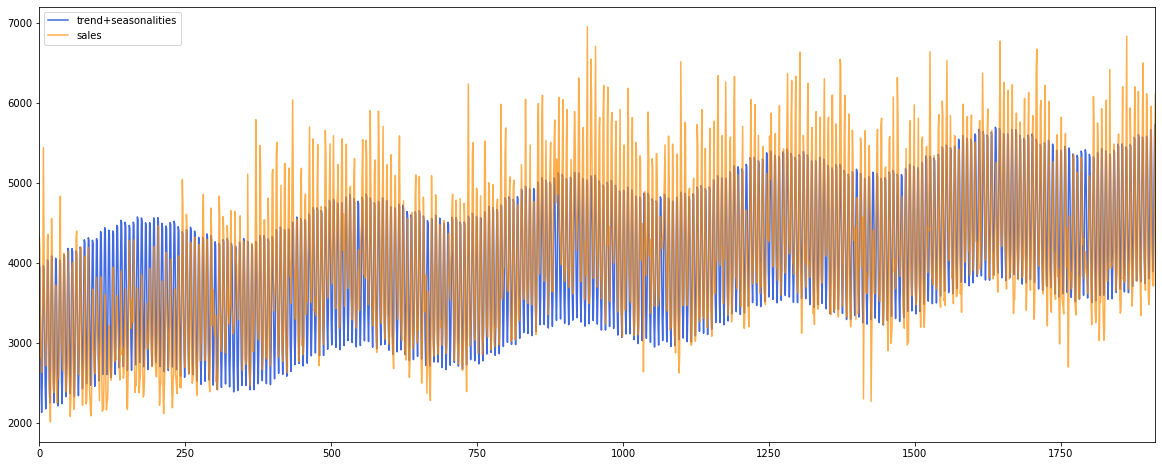

In [ ]:
#Signal = trend + seasonalities + noise
trend = model.intercept_ + model.coef_[0][0]*np.array(predic1)
seas_annual = model.coef_[0][1]*np.array(predic_annual_cos) + model.coef_[0][2]*np.array(predic_annual_sin)
seas_month = model.coef_[0][3]*np.array(predic_month_cos) + model.coef_[0][4]*np.array(predic_month_sin)
seas_week = model.coef_[0][5]*np.array(predic_week_cos) + model.coef_[0][6]*np.array(predic_week_sin)

trend_seas = trend + seas_annual + seas_month + seas_week

ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8), color= 'royalblue')
y_sales.plot(ax=ax,alpha=0.7, color= 'darkorange')

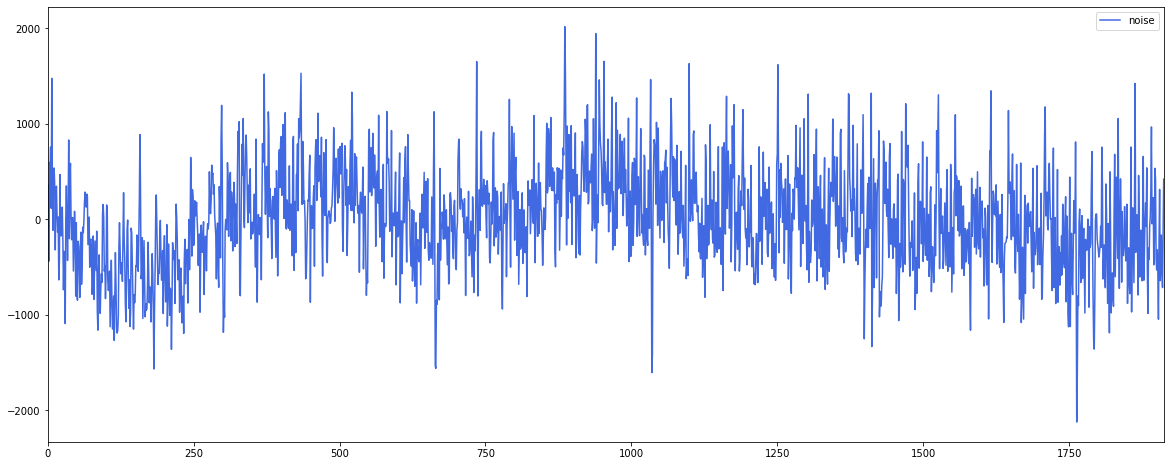

In [ ]:
#Plotting the noise
y_adjusted = np.array(list(y_sales['sales'])) - trend_seas
y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
y_adjusted.plot(figsize=(20,8), color= 'royalblue')

Let's model the noise with SARIMA now.

# Splitting the dataset

In [ ]:
y_train = y_adjusted.iloc[:-28,]
y_test = y_adjusted.iloc[-28:,]

# SARIMA

Parameters were estimated using a grid search (see Appendix):

/Users/bertrandthia/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             noise   No. Observations:                 1885
Model:             SARIMAX(2, 1, 5)x(2, 0, 1, 7)   Log Likelihood              -13828.748
Date:                           Thu, 21 May 2020   AIC                          27679.495
Time:                                   18:37:20   BIC                          27740.448
Sample:                                        0   HQIC                         27701.943
                                          - 1885                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4428      0.029    -15.228      0.000      -0.500      -0.386
ar.L2         -0.9804      0.027    -35.659

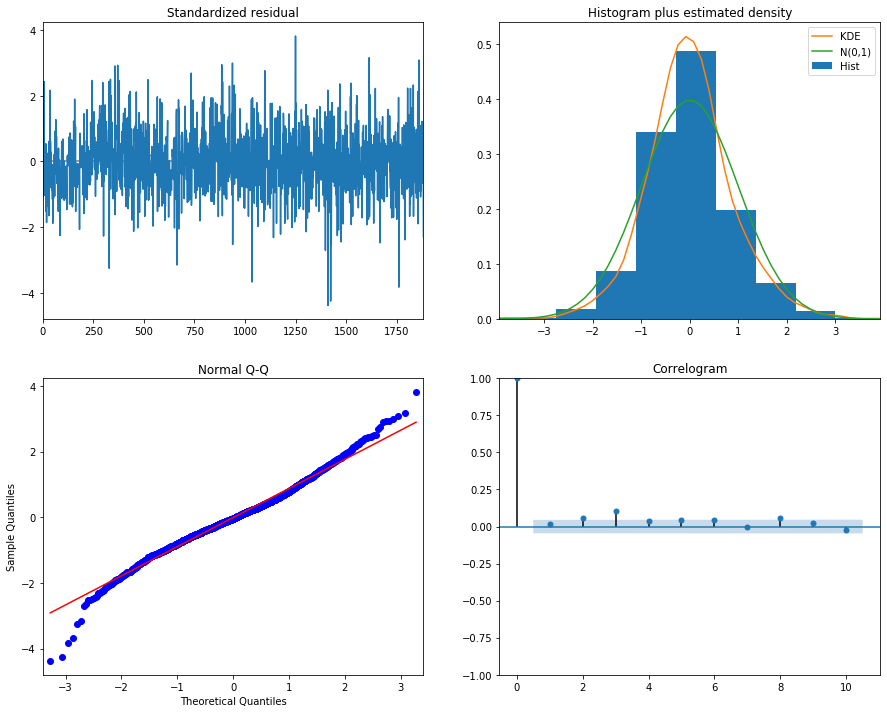

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2, 1, 5),
                                seasonal_order=(2, 0, 1, 7))
results = mod.fit()

print(results.summary())

results.plot_diagnostics(figsize=(15, 12))
plt.show()

The SARIMA model looks "healthy".

# Test

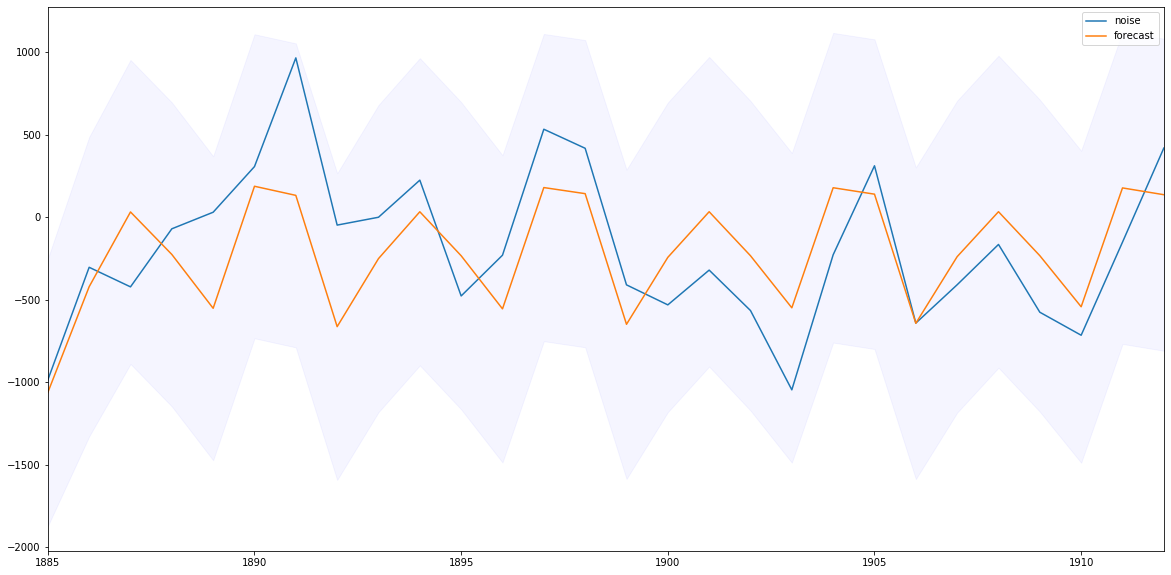

In [ ]:
# Plot of the test noise 

pred = results.get_forecast(steps=28)

ax = y_test.plot(figsize=(20, 10))

pd.DataFrame(pred.predicted_mean, columns=['forecast']).plot(ax=ax)

ax.fill_between(range(1885,1913), pred.conf_int()['lower noise'], pred.conf_int()['upper noise'], 
                color='b', alpha=.04)

plt.legend()
plt.show()

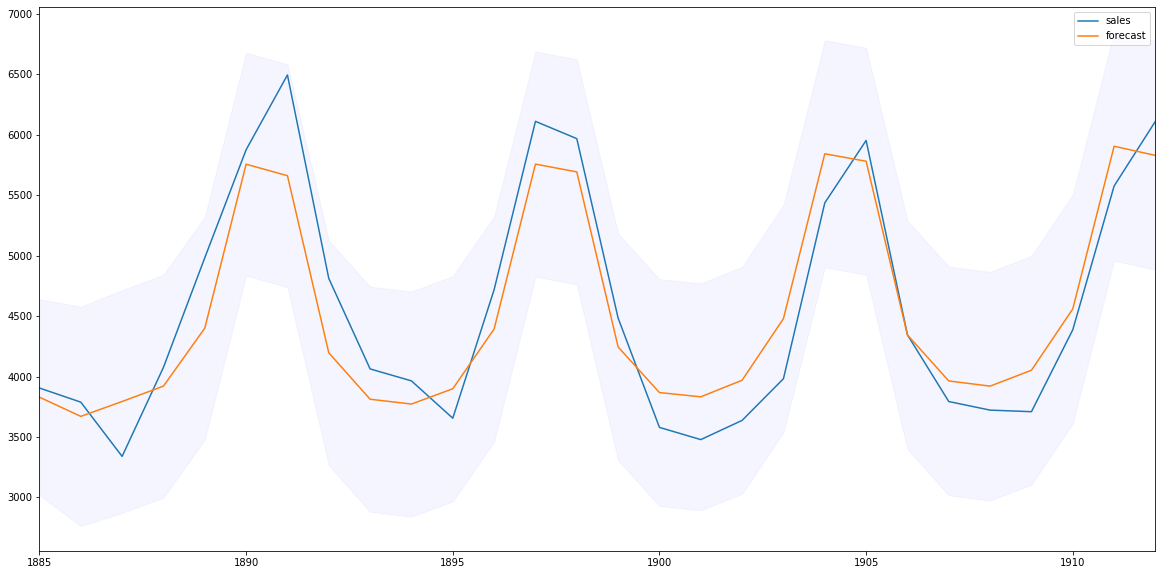

In [ ]:
# Plot of the noise + trend + seasonality

ax = pd.DataFrame(np.array(list(y_test['noise']))+trend_seas[1885:],
                  index = range(1885,1913), columns=['sales']).plot(figsize=(20, 10))

pd.DataFrame(pred.predicted_mean+trend_seas[1885:], columns=['forecast']).plot(ax=ax)

ax.fill_between(range(1885,1913), pred.conf_int()['lower noise']+trend_seas[1885:], 
                pred.conf_int()['upper noise']+trend_seas[1885:], color='b', alpha=.04)

plt.legend()
plt.show()

In [ ]:
print('RMSSE:', RMSSE(pd.DataFrame(np.array(list(y_train['noise']))+trend_seas[:1885]), 
                      np.array(list(y_test['noise']))+trend_seas[1885:], 
                      (pred.predicted_mean+trend_seas[1885:]).values))

RMSSE: 0.4358503701548446


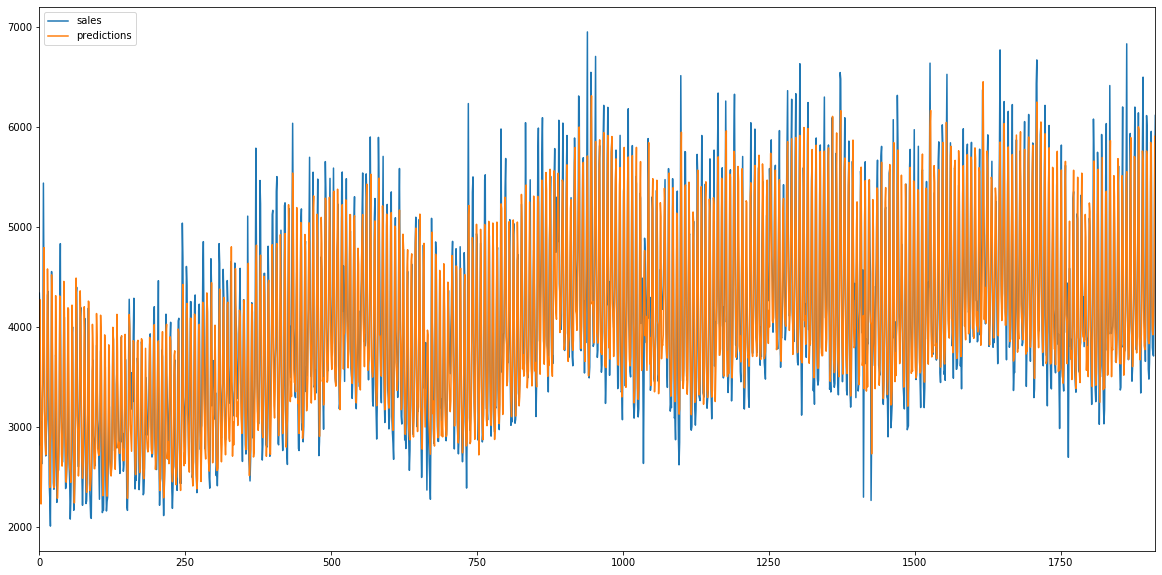

In [ ]:
# Plot of the whole curve (train + test)

pred_all = results.predict(start=0, end=1912)

ax = y_sales.plot(figsize=(20, 10))

pd.DataFrame(pred_all + trend_seas, columns=['predictions']).plot(ax=ax)

plt.legend()
plt.show()

The results look satisfying. Let's generalize our method to the other stores now.

# Doing the same for the other stores

## Helper functions

These functions wrap up our previous processings to ease the treatment of the data and the modeling:

In [ ]:
def preprocessing(data):
    '''
    Remove the trend and seasonality of data and split it into a train and validation sets
    '''
    #Unit sales of all products aggregated
    all_data = data[d_cols].sum(axis=0).T.reset_index()
    all_data.columns = ['d','sales']
    # Merge with the calendar
    all_data_merged = all_data.merge(cal, how='left', validate='1:1')

    y = all_data_merged.set_index('date')['sales']

    #Detect days that have either event_1 or event_2
    places = all_data_merged.loc[~(all_data_merged['event_name_1'].isna()) | 
                                 ~(all_data_merged['event_name_2'].isna())]['d']
    # Replace the outliers by the mean
    change = list(all_data_merged.d.isin(list(places)))
    for i in range(len(change)):
        if change[i] == True:
            y.iloc[i] = (y.iloc[i-1] + y.iloc[i+1]) / 2

    y_sales = y.reset_index().drop(['date'],axis=1)
    #Time scale
    predic1 = range(1913)
    #Applying the Fourier series to the time scale
    predic_annual_cos = list(map(lambda x: np.cos(2*np.pi*x/365), predic1))
    predic_annual_sin = list(map(lambda x: np.sin(2*np.pi*x/365), predic1))
    predic_month_cos = list(map(lambda x: np.cos(2*np.pi*x/30), predic1))
    predic_month_sin = list(map(lambda x: np.sin(2*np.pi*x/30), predic1))
    predic_week_cos = list(map(lambda x: np.cos(2*np.pi*x/7), predic1))
    predic_week_sin = list(map(lambda x: np.sin(2*np.pi*x/7), predic1))
    #assembling the regressors
    reg = pd.DataFrame(list(zip(predic1, predic_annual_cos, predic_annual_sin, predic_month_cos, 
                                predic_month_sin, predic_week_cos, predic_week_sin)), 
                   columns =['predic1', 'predic_annual_cos', 'predic_annual_sin', 
                             'predic_month_cos', 'predic_month_sin', 'predic_week_cos', 'predic_week_sin']) 
    #Model
    model = LinearRegression().fit(reg, y_sales)
    #The estimated parameters
    r2 = model.score(reg, y_sales)
    print('coefficient of determination:', r2)
    
    trend = model.intercept_ + model.coef_[0][0]*np.array(predic1)
    seas_annual = model.coef_[0][1]*np.array(predic_annual_cos) + model.coef_[0][2]*np.array(predic_annual_sin)
    seas_month = model.coef_[0][3]*np.array(predic_month_cos) + model.coef_[0][4]*np.array(predic_month_sin)
    seas_week = model.coef_[0][5]*np.array(predic_week_cos) + model.coef_[0][6]*np.array(predic_week_sin)

    trend_seas = trend + seas_annual + seas_month + seas_week
    
    y_adjusted = np.array(list(y_sales['sales'])) - trend_seas
    y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
    
    y_train = y_adjusted.iloc[:-28,]
    y_test = y_adjusted.iloc[-28:,]
    return y_train, y_test

In [ ]:
def get_RMSSE(y_train, y_test):
    '''
    Fit the train set with a SARIMA model and return the RMSSE on the test data
    '''
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2, 1, 5),
                                seasonal_order=(2, 0, 2, 14))
    results = mod.fit()
    
    # Plot of the noise + trend + seasonality
    ax = pd.DataFrame(np.array(list(y_test['noise']))+trend_seas[1885:],
                      index = range(1885,1913), columns=['sales']).plot(figsize=(20, 10))
    pd.DataFrame(pred.predicted_mean+trend_seas[1885:], columns=['forecast']).plot(ax=ax)
    ax.fill_between(range(1885,1913), pred.conf_int()['lower noise']+trend_seas[1885:], 
                    pred.conf_int()['upper noise']+trend_seas[1885:], color='b', alpha=.04)
    plt.legend()
    plt.show()
    
    # get rmsse
    return RMSSE(pd.DataFrame(np.array(list(y_train['noise']))+trend_seas[:1885]), 
                      np.array(list(y_test['noise']))+trend_seas[1885:], 
                      (pred.predicted_mean+trend_seas[1885:]).values)

## Plotting the results

Store: CA_1
coefficient of determination: 0.7015771123337059


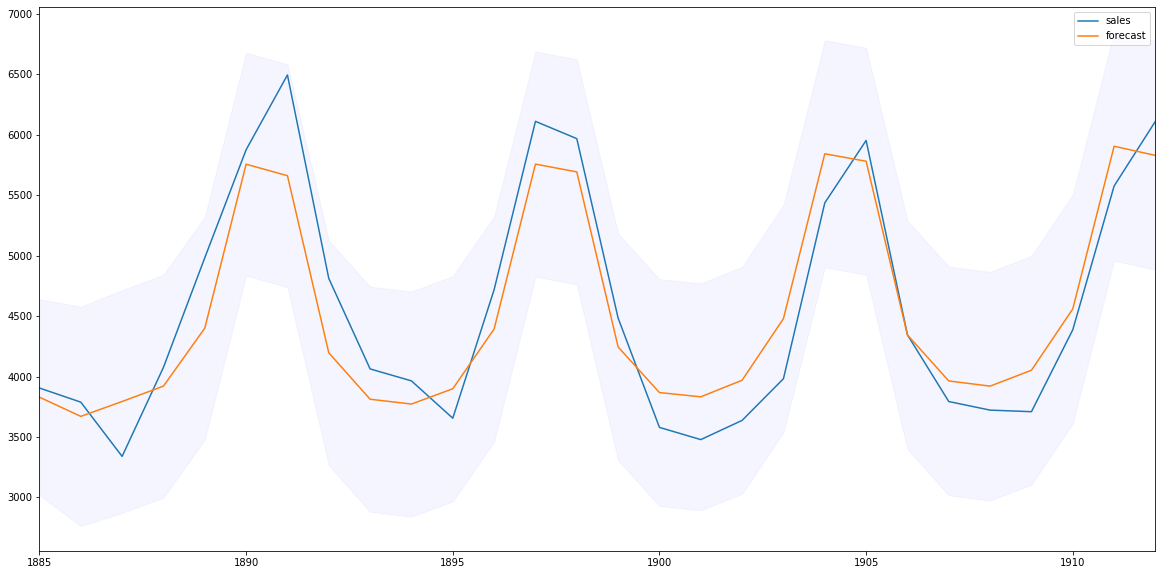

Store: CA_2
coefficient of determination: 0.5641741208307305


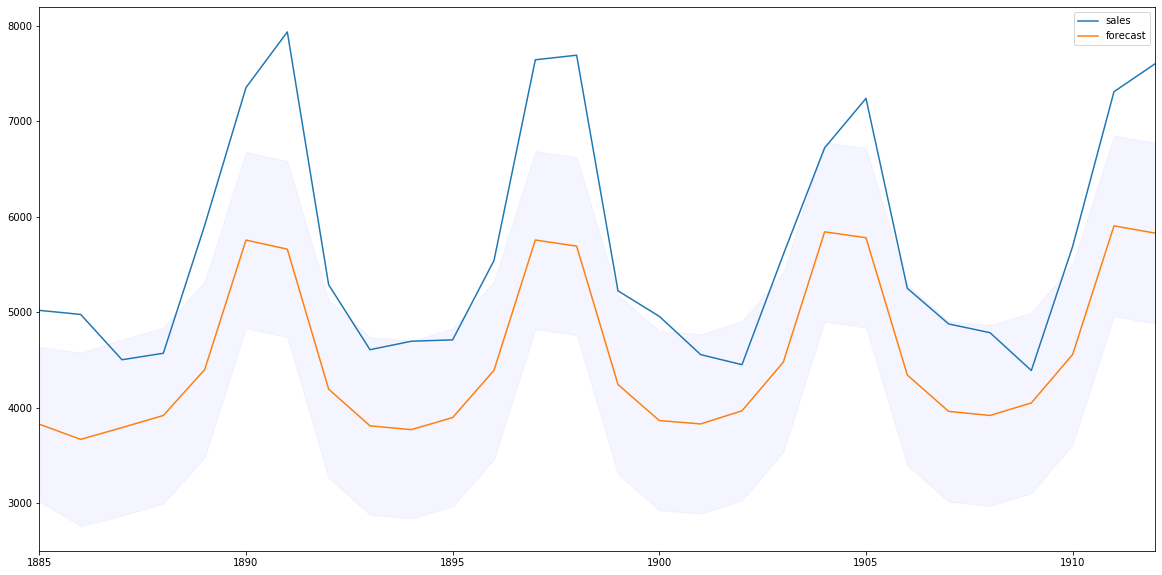

Store: CA_3
coefficient of determination: 0.5818259483592871


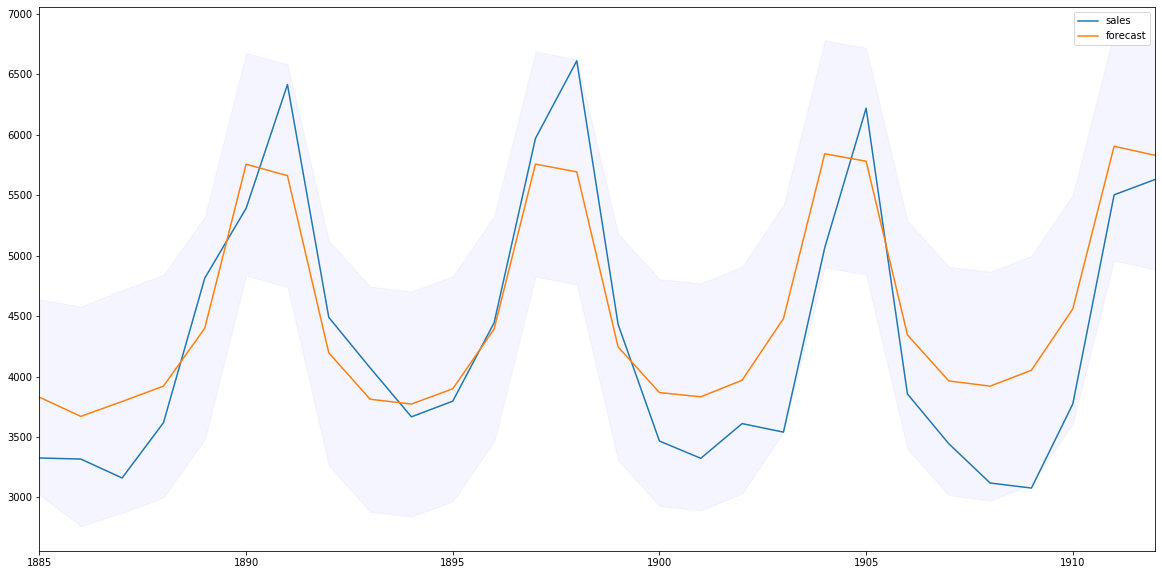

Store: CA_4
coefficient of determination: 0.6919161065648596


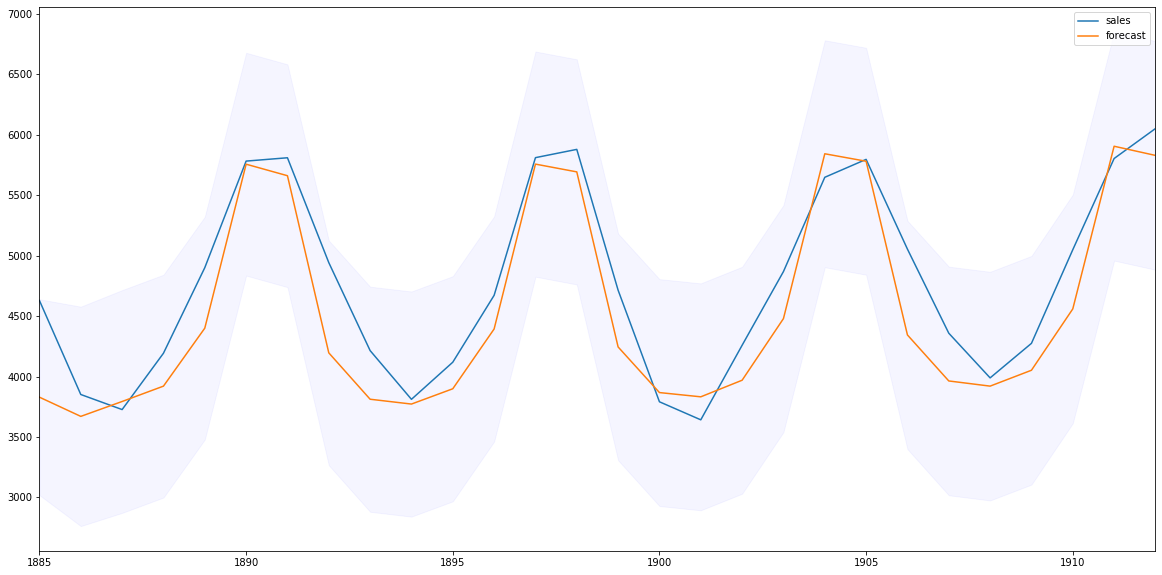

Store: TX_1
coefficient of determination: 0.5697004470344348


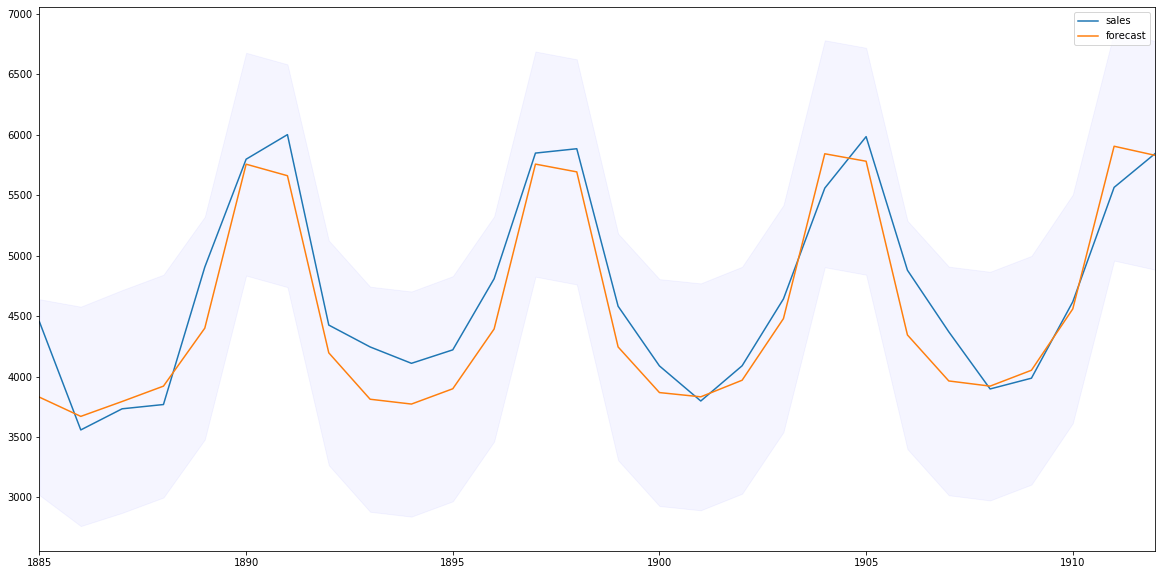

Store: TX_2
coefficient of determination: 0.4491643860420008


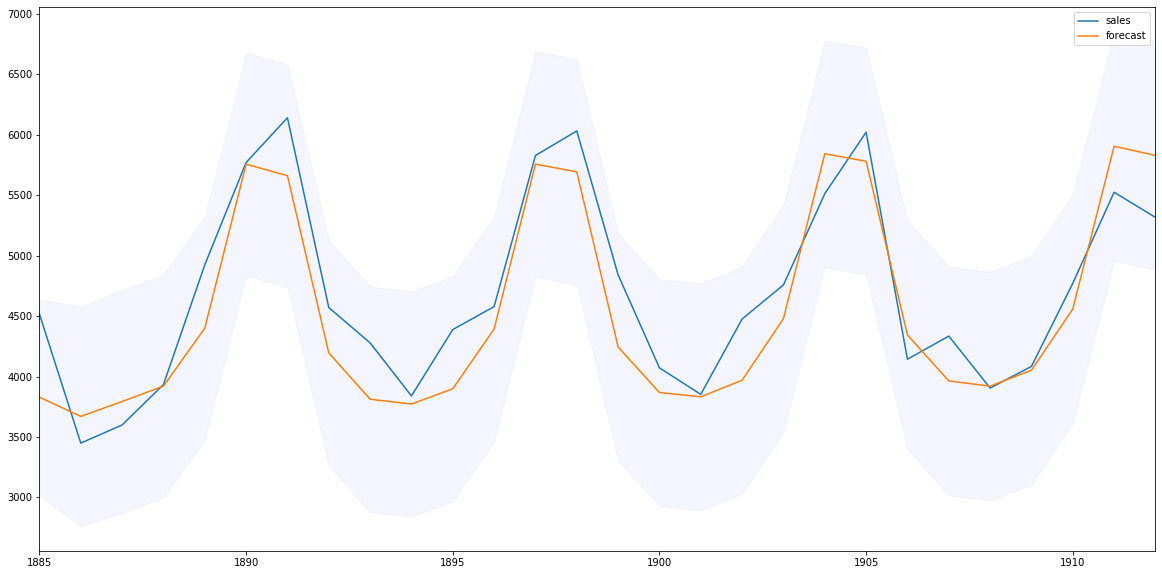

Store: TX_3
coefficient of determination: 0.6872735052544574


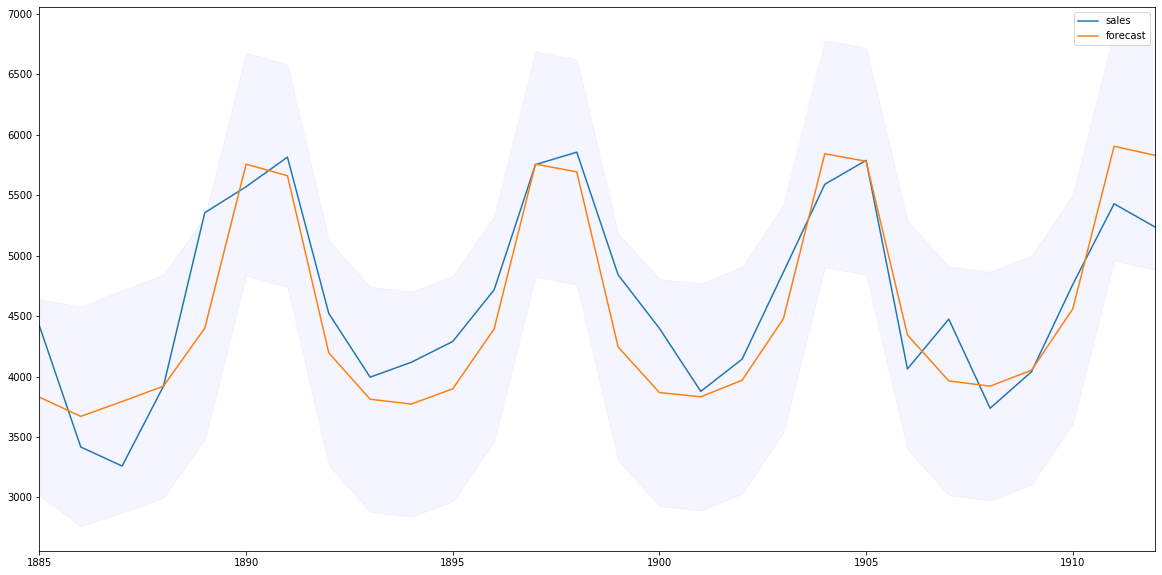

Store: WI_1
coefficient of determination: 0.7781314796241122


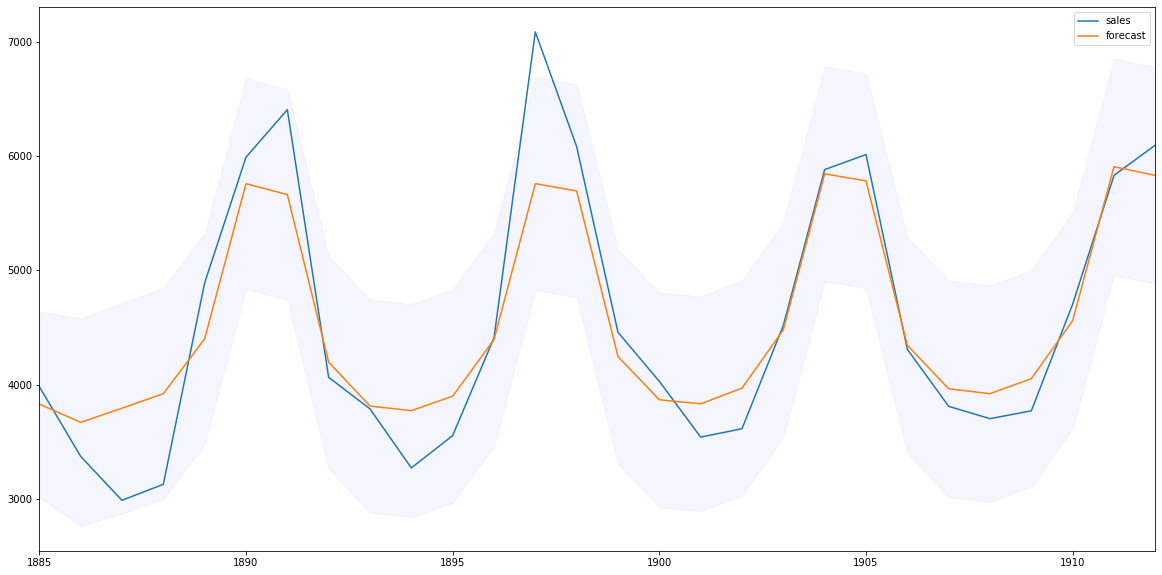

Store: WI_2
coefficient of determination: 0.6043269035682703


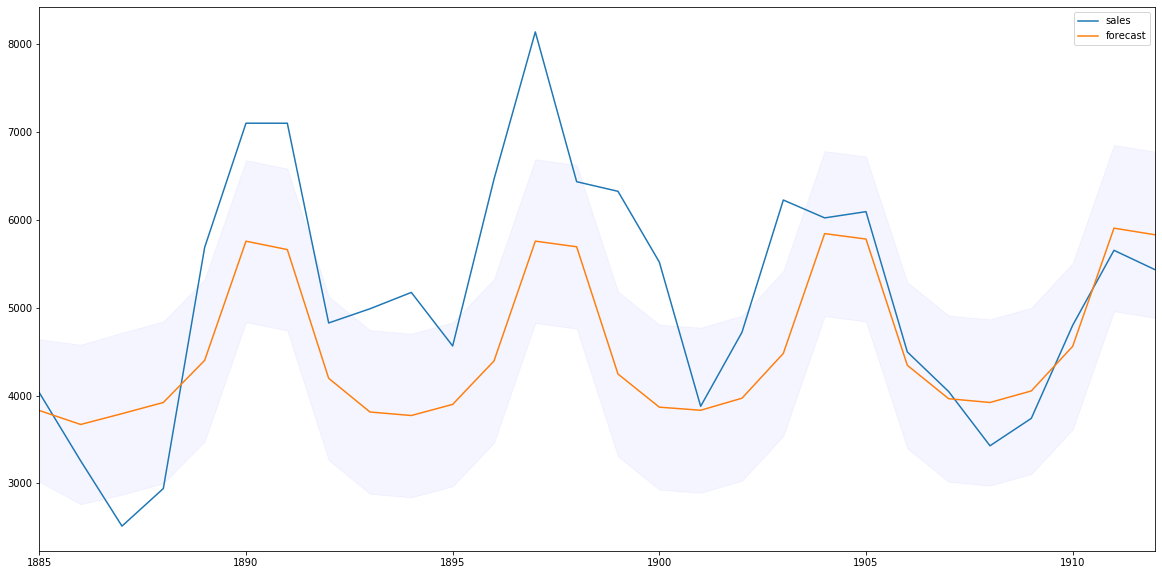

Store: WI_3
coefficient of determination: 0.3032869448320197


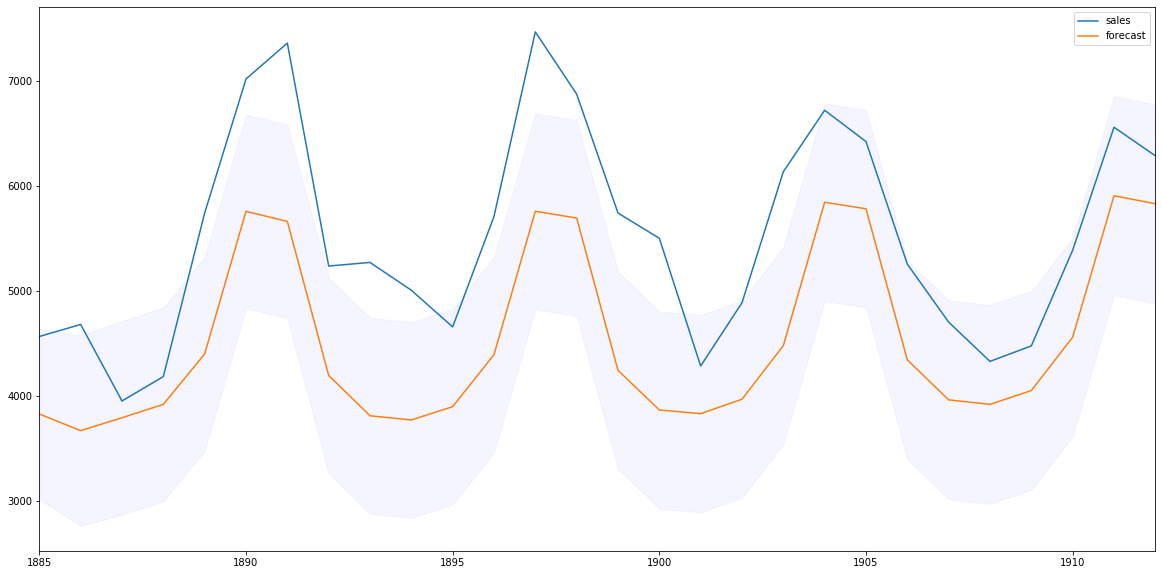

In [ ]:
rmsse_list = []
stores_list = list(stv.store_id.unique())
for store in stores_list:
    print('Store:', store)
    data = stv[stv['store_id'] == store]
    y_train, y_test = preprocessing(data)
    rmsse = get_RMSSE(y_train, y_test)
    rmsse_list.append(rmsse)

In [ ]:
print('Mean RMSSE:', np.mean(rmsse_list))

Mean RMSSE: 0.7899777111617631


In [ ]:
rmsse_list

[0.4358503701548446,
 1.5922338454657048,
 0.6249029787299201,
 0.5654418565789798,
 0.40242755489075,
 0.438767913813683,
 0.5439875548565319,
 0.5561397124910324,
 1.3527164407589787,
 1.3873088838772056]

---
# Appendix

### Grid search parameter

We ran the following code two times: one time to get the optimal (p,q,d) for fixed (P,Q,D,s), and then one time to get the optimal (P,Q,D,s) with the optimal (p,q,d) found. This may not lead to the optimal solution overall, but the search space was too large and it was taking too much time otherwise. 

We chose to do our grid search with the store `WI_2` as we noticed our model tended to have the more trouble at predicting its sales.   

In [ ]:
verbose = True
store = 'WI_2'

data = stv[stv['store_id'] == store]
y_train, y_test = preprocessing(data)

# Define the p and q parameters to take any value between 0 and 4, d between 0 and 1
p = q = range(0, 3)
d = [0,1,2]
# Generate all different combinations of p, q and q triplets
#pdq = list(itr.product(p, d, q))
pdq = [[2,1,5]]
# Generate all different combinations of seasonal p, q and q triplets
P = Q = range(0, 3)
D = [0,1,2]
s = [1,7,14]
seasonal_pdq = list(itr.product(P, D, Q, s))

warnings.filterwarnings("ignore") # specify to ignore warning messages
minimum = 500000 #initialize the minimum AIC variable with a high enough value
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal)
            results = mod.fit()
            if results.aic < minimum:
                minimum = results.aic
                param_ideal = (param, param_seasonal)
            if verbose:
                print('SARIMA{} - AIC:{}'.format((param, param_seasonal), results.aic))
        except:
            print('none')
            continue
            
print('And the result is SARIMA{} - AIC:{}'.format(param_ideal, minimum))

coefficient of determination: 0.6043269035682703
SARIMA([2, 1, 5], (0, 0, 0, 1)) - AIC:28759.19998689331
SARIMA([2, 1, 5], (0, 0, 0, 7)) - AIC:28759.19998689331
SARIMA([2, 1, 5], (0, 0, 0, 14)) - AIC:28759.19998689331
SARIMA([2, 1, 5], (0, 0, 1, 1)) - AIC:28713.897869083
SARIMA([2, 1, 5], (0, 0, 1, 7)) - AIC:28755.091429416047
SARIMA([2, 1, 5], (0, 0, 1, 14)) - AIC:28757.785884632645
SARIMA([2, 1, 5], (0, 0, 2, 1)) - AIC:28697.98038277207
SARIMA([2, 1, 5], (0, 0, 2, 7)) - AIC:28754.641141523847
SARIMA([2, 1, 5], (0, 0, 2, 14)) - AIC:28621.70846404883
SARIMA([2, 1, 5], (0, 1, 0, 1)) - AIC:28815.466035164813
SARIMA([2, 1, 5], (0, 1, 0, 7)) - AIC:29417.662129783806
SARIMA([2, 1, 5], (0, 1, 0, 14)) - AIC:29663.273120792262
SARIMA([2, 1, 5], (0, 1, 1, 1)) - AIC:28755.598428061996
SARIMA([2, 1, 5], (0, 1, 1, 7)) - AIC:28627.66689171407
SARIMA([2, 1, 5], (0, 1, 1, 14)) - AIC:28640.738940229883
SARIMA([2, 1, 5], (0, 1, 2, 1)) - AIC:28730.377785864526
SARIMA([2, 1, 5], (0, 1, 2, 7)) - AIC:28637

The grid search is extremely long!